In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import train_test_split

dataset_path = "./datasets/ddos_balanced/final_dataset.csv"

2024-04-28 20:46:20.083546: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 20:46:20.214899: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-28 20:46:20.792409: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-28 20:46:30.432912: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/iwachan/IDS/venv/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning:

Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This

## Data Processing

In [2]:
def data_processing(path, p=0.1):
  df_dataset = pd.read_csv(path, skiprows=lambda i: i>0 and random.random() > p)

  colToDrop = np.array(['Unnamed: 0','Flow ID', 'Src IP', 'Dst IP', 'Timestamp'])
  df_dataset = df_dataset.drop(colToDrop, axis=1)
  df_dataset.replace([np.inf, -np.inf], np.nan, inplace=True)
  df_dataset.dropna(inplace=True)

  df_dataset.replace(to_replace="Benign", value=0, inplace=True)
  df_dataset.replace(to_replace="ddos", value=1, inplace=True)

  return df_dataset

In [3]:
def plot_class_distribution(df_dataset):
       from plotly.offline import init_notebook_mode, iplot, plot
       import plotly as py
       import plotly.express as px
       init_notebook_mode(connected=True)
       import plotly.graph_objs as go

       fig = go.Figure(data=[
       go.Bar(name='Benign', 
              y=df_dataset["Label"].value_counts().values[0:1],
              x=['Benign'],
              text = df_dataset["Label"].value_counts()[0:1],
              orientation='v',
              textposition='outside',),
       go.Bar(name='DDoS', 
              y=df_dataset["Label"].value_counts().values[1:2],
              x=['ddos'],
              text = df_dataset["Label"].value_counts()[1:2],
              orientation='v',
              textposition='outside',)
       ])

       fig.update_layout(
                     width=800,
                     height=600,
                     title=f'Class Distribution',
                     yaxis_title='Number of attacks',
                     xaxis_title='Attack Name',)
       iplot(fig)

In [8]:
def normalize(train, test):
       from sklearn.preprocessing import MinMaxScaler

       numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
              'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
              'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
              'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
              'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
              'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
              'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
              'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
              'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
              'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
              'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
              'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
              'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
              'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
              'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
              'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
              'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
              'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
              'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
              'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
              'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

       min_max_scaler = MinMaxScaler().fit(train[numerical_columns])
       train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])
       test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])

       return train, test
       

## Models

In [18]:
def DNN_model(input_size):
  neuralNetworkModel = keras.Sequential([
    layers.InputLayer(shape=(input_size,)),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation='sigmoid'),
  ])

  print(neuralNetworkModel.summary())
  return neuralNetworkModel

In [16]:
def compile_model(model, X_train, y_train, isDL=True):
    if isDL:
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=0.01)

        early_stopping = callbacks.EarlyStopping(
            monitor='loss', 
            min_delta = 0.001,
            patience = 5,
            restore_best_weights = True
        )

        model.compile(
            optimizer=optimizer,
            loss='binary_crossentropy',
            metrics=['binary_accuracy'],
        )
        history = model.fit(
        X_train, y_train,
        epochs=50,
        batch_size = 256,
        callbacks=[early_stopping]
        )

        # summarize history for accuracy
        plt.plot(history.history['binary_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train'], loc='upper left')
        plt.show()
    else:
        pass

    return model
    


## Testing Model Function

In [28]:
def test_model(model, X_test, y_test):
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
    import seaborn as sns

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred)

    # Accuracy 
    acc = accuracy_score(y_test, y_pred)
    print('\nAccuracy')
    print(acc)

    # Precision 
    prec = precision_score(y_test, y_pred)#,average='macro')
    print('\nPrecision')
    print(prec)

    # Recall
    rec = recall_score(y_test, y_pred) #,average='macro')
    print('\nRecall')
    print(rec)

    # F1 score
    f1 = f1_score(y_test,y_pred) #,average='macro')
    print('\nF1 Score')
    print(f1)

    # Confusion Matrix
    print('\nConfusion Matrix')
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt='g')

    return acc, prec, rec, f1, cf_matrix

## Building Models

In [ ]:
df = data_processing(dataset_path)
plot_class_distribution(df)

In [ ]:
RANDOM_STATE_SEED = 12
train, test = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE_SEED)

print("Full dataset:\n")
print("Benign: " + str(df["Label"].value_counts()[[0]].sum()))
print("DDoS: " + str(df["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("DDoS: " + str(train["Label"].value_counts()[[1]].sum()))
y_train = np.array(train.pop("Label"))
X_train = train.values
print("X_train shape: ", X_train.shape)
print("y_train shape", y_train.shape)
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("DDoS: " + str(test["Label"].value_counts()[[1]].sum()))
y_test = np.array(test.pop("Label"))
X_test = test.values
print("X_test shape: ",X_test.shape)
print("y_test shape", y_test.shape)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_15          │ (None, 79)             │           316 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 256)            │        20,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 63,549 (248.24 KB)

 Trainable params: 62,623 (244.62 KB)

 Non-trainable params: 926 (3.62 KB)

None
Epoch 1/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - binary_accuracy: 0.9623 - loss: 0.0990
Epoch 2/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - binary_accuracy: 0.9936 - loss: 0.0215
Epoch 3/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - binary_accuracy: 0.9953 - loss: 0.0162
Epoch 4/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - binary_accuracy: 0.9960 - loss: 0.0143
Epoch 5/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 28s 7ms/step - binary_accuracy: 0.9964 - loss: 0.0129
Epoch 6/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 25s 6ms/step - binary_accuracy: 0.9965 - loss: 0.0122
Epoch 7/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 22s 6ms/step - binary_accuracy: 0.9969 - loss: 0.0111
Epoch 8/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - binary_accuracy: 0.9969 - loss: 0.0108
Epoch 9/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - binary_accuracy: 0.9971 - loss: 0.0101
Epoch 10/50
3987/3987 ━━━━━━━━━━━━━━━━━━━━ 22s 5ms/step - binary_accuracy: 0.9971 - loss: 0.0098
Epoch 11/50
3987/3987 ━━━━━━━━━━━━

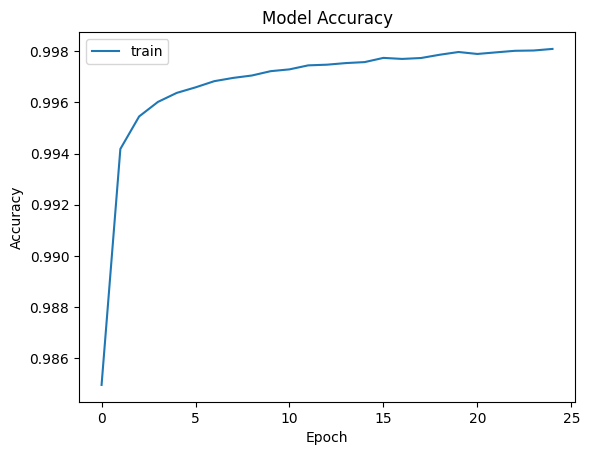

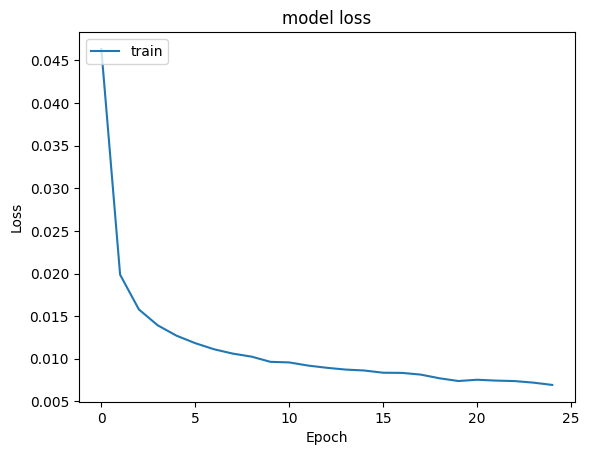

In [24]:
_features = X_train.shape[1]
dnn_model = DNN_model(_features)
dnn_model = compile_model(dnn_model, X_train, y_train)

7974/7974 ━━━━━━━━━━━━━━━━━━━━ 6s 794us/step

Accuracy
0.997342749979424

Precision
0.9972584806129914

Recall
0.9975196616880165

F1 Score
0.9973890540519724

Confusion Matrix


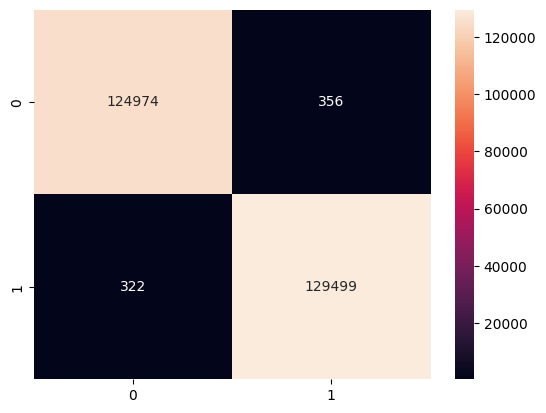

In [29]:
acc, prec, rec, f1, cf_matrix = test_model(dnn_model, X_test ,y_test)